# Microcontroller Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

## Get data

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
!wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
!unzip microcontroller_segmentation_data.zip
!ls

--2021-08-13 11:20:11--  https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/master/microcontroller_segmentation_data.zip [following]
--2021-08-13 11:20:11--  https://raw.githubusercontent.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/master/microcontroller_segmentation_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17521676 (17M) [application/zip]
Saving to: ‘microcontroller_segmenta

In [4]:
!ls 'Microcontroller Segmentation'

labelme2coco.py  test  test.json  train  train.json


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [5]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"microcontroller_{d}", {}, f"Microcontroller Segmentation/{d}.json", f"Microcontroller Segmentation/{d}")

WARNING [08/13 11:20:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/13 11:20:13 d2.data.datasets.coco]: Loaded 142 images in COCO format from Microcontroller Segmentation/train.json


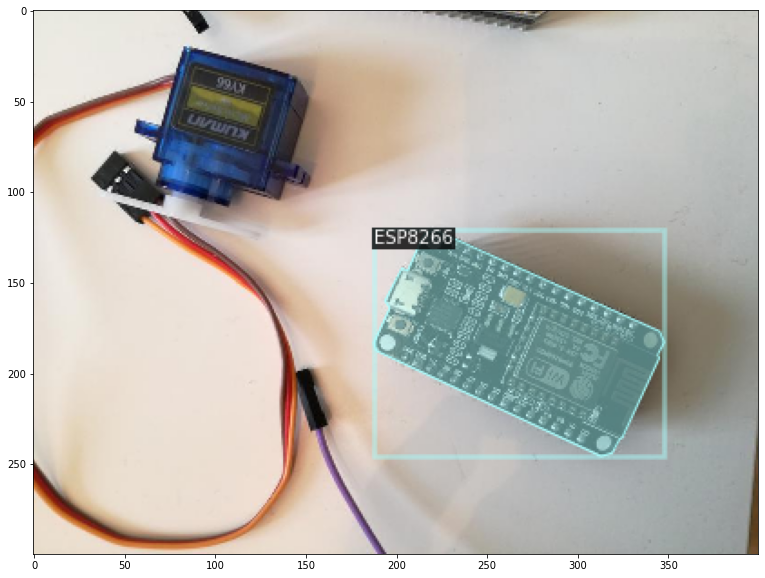

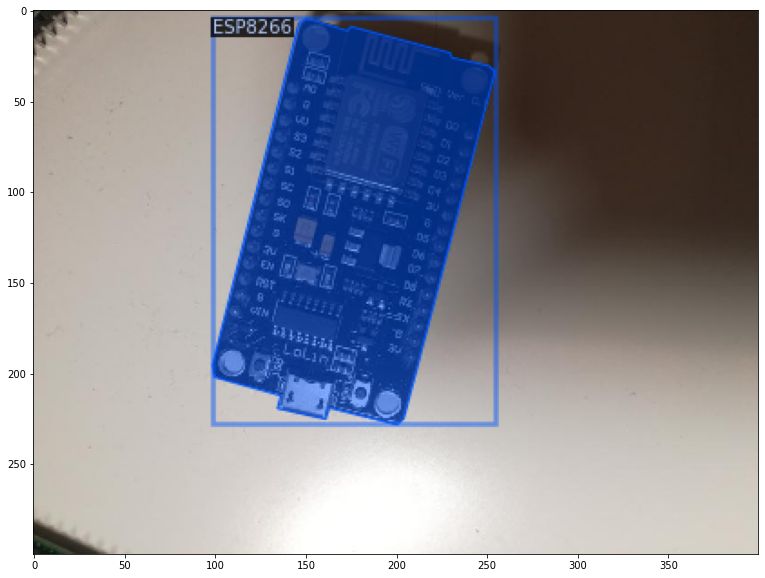

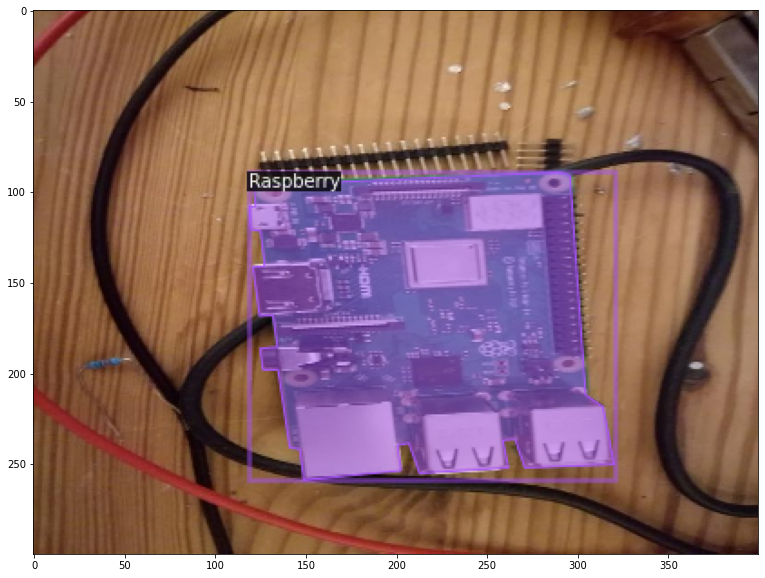

In [6]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("microcontroller_train")
microcontroller_metadata = MetadataCatalog.get("microcontroller_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/13 11:20:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 67.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[08/13 11:20:31 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[08/13 11:20:40 d2.utils.events]:  eta: 0:07:13  iter: 19  total_loss: 2.606  loss_cls: 1.773  loss_box_reg: 0.1191  loss_mask: 0.6933  loss_rpn_cls: 0.00575  loss_rpn_loc: 0.003896  time: 0.4348  data_time: 0.0168  lr: 4.9953e-06  max_mem: 2341M
[08/13 11:20:48 d2.utils.events]:  eta: 0:06:46  iter: 39  total_loss: 2.413  loss_cls: 1.586  loss_box_reg: 0.1205  loss_mask: 0.6892  loss_rpn_cls: 0.004679  loss_rpn_loc: 0.003747  time: 0.4262  data_time: 0.0067  lr: 9.9902e-06  max_mem: 2341M
[08/13 11:20:57 d2.utils.events]:  eta: 0:06:36  iter: 59  total_loss: 2.129  loss_cls: 1.257  loss_box_reg: 0.1495  loss_mask: 0.6787  loss_rpn_cls: 0.005388  loss_rpn_loc: 0.00477  time: 0.4254  data_time: 0.0073  lr: 1.4985e-05  max_mem: 2341M
[08/13 11:21:06 d2.utils.events]:  eta: 0:06:31  iter: 79  total_loss: 1.707  loss_cls: 0.8669  loss_box_reg: 0.1536  loss_mask: 0.6655  loss_rpn_cls: 0.007994  loss_rpn_loc: 0.003528  time: 0.4301  data_time: 0.0077  lr: 1.998e-05  max_mem: 2341M
[08/13 11:

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("microcontroller_test", )
predictor = DefaultPredictor(cfg)

WARNING [08/13 11:28:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/13 11:28:22 d2.data.datasets.coco]: Loaded 142 images in COCO format from Microcontroller Segmentation/train.json


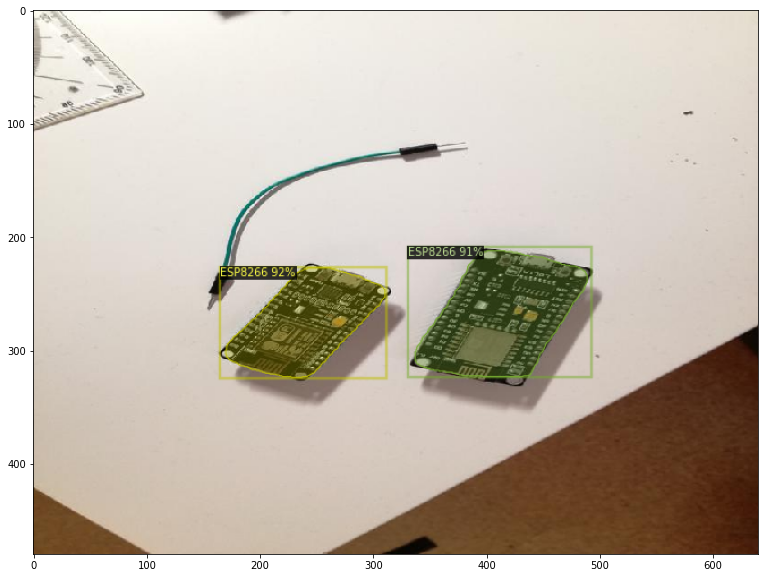

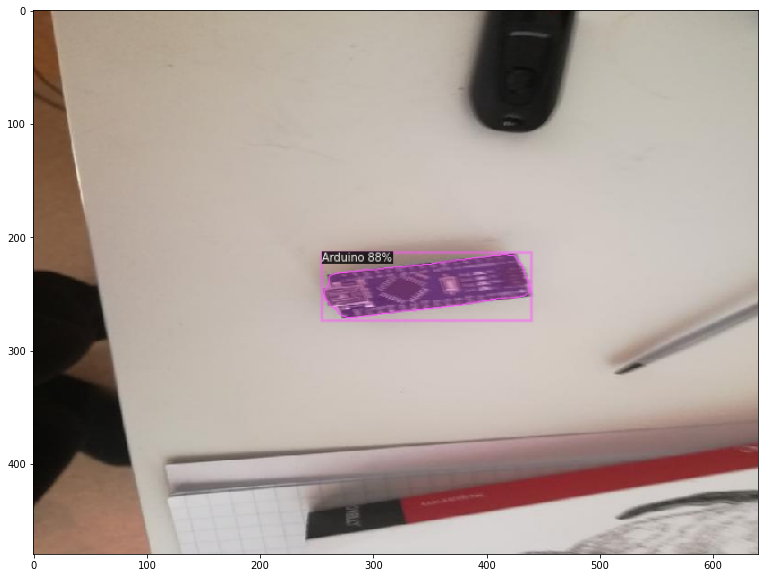

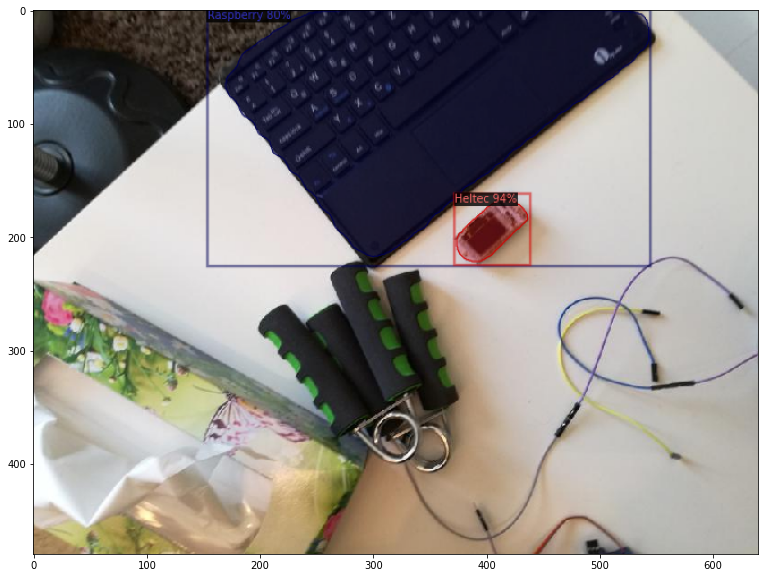

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("microcontroller_train")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()